# Moving Average Price Reversion

## Strategy

We assume that when an asset is trading above its moving average, it is overvalued and will revert to its moving average in price, acting as a signal to sell or short the asset. Conversely, when an asset is trading below its moving average, we assume that it is undervalued and will also revert to its moving average in price, acting as a signal to buy the asset.

Despite the fact that performance below the moving average does not necessarily imply strong performance in the next period (e.g. the moving average could be lower so that the price could revert to the mean and be yet lower), we still explore this strategy with an assumption that the time series are relatively stationary in the short term.

We consider the following dimensions of variation:
  - time horizons for measuring price and trading: 4h, 8h, 12h, 1d, 2d
  - signal calculation of price relative to average: raw difference, percent change
  - type of moving average: simple moving average vs. exponentially weighted moving average
  - for simple moving average, window size for simple moving average
  - for exponentially weighted-moving average, alpha decay
  - original signal, winsorization, truncation, rank-thresholding of signal
  
We also consider using the following transformations of the original signal:
- (1) winsorizing the signal (10% on each side)
- (2) truncating the signal (10% on each side)
- (3) rank-thresholding the signal (20% on each side)


## Data Collection

The universe of cryptocurrencies is based on [this snapshot](https://coinmarketcap.com/historical/20201220/) from December 20, 2020 of major crytocurrencies. We use this set of cryptocurrencies to avoid survivor bias, with the period from December 20, 2020 to December 31, 2023 being the period when we try the different variations. We then test the three best performing variations of the strategy during the period form January 1, 2024 to August 31, 2025.


## Implementation

Most functions used here are defined in [this utility functions file](https://github.com/wbchristerson/crypto-strategies/blob/main/utility_functions.ipynb). Below, we implement a grid search over the parameter variations.


## Transaction Costs

We account for commissions and slippage by assuming 20 basis points of cost per dollar of turnover.


## Results

TO BE FILLED IN

# Imports

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

from binance.client import Client as bnb_client
from datetime import datetime, timedelta

from ipynb.fs.full.utility_functions import (
    get_train_test_data,
    get_rank_demeaned_normalized_signal,
    get_gross_returns_and_net_returns,
    get_strategy_stats,
    get_winsorized_signal,
    get_truncated_signal,
    get_rank_thresholded_signal,
    get_price_data,
    plot_gross_and_net_cumulative_returns,
)

# Price Data Collection

In [45]:
univ = [
    "BTCUSDT", "ETHUSDT", "ADAUSDT", "BNBUSDT", "XRPUSDT", "DOTUSDT", "MATICUSDT", "LTCUSDT", "BCHUSDT",
    "LINKUSDT", "XLMUSDT", "USDCUSDT", "EOSUSDT", "TRXUSDT", "XTZUSDT", "FILUSDT", "NEOUSDT", "DAIUSDT",
    "DASHUSDT", "VETUSDT", "ATOMUSDT", "AAVEUSDT", "UNIUSDT", "GRTUSDT", "THETAUSDT", "IOTAUSDT", "BUSDUSDT",
    "ZECUSDT", "YFIUSDT", "ETCUSDT", "WAVESUSDT", "COMPUSDT", "SNXUSDT", "DOGEUSDT", "MKRUSDT", "ZILUSDT",
    "SUSHIUSDT", "KSMUSDT", "OMGUSDT", "ONTUSDT", "ALGOUSDT", "EGLDUSDT", "BATUSDT", "DGBUSDT", "ZRXUSDT",
    "TUSDUSDT", "QTUMUSDT", "ICXUSDT", "AVAXUSDT", "RENUSDT", "HBARUSDT", "NEARUSDT", "LRCUSDT", "CELOUSDT",
    "KNCUSDT", "LSKUSDT", "OCEANUSDT", "QNTUSDT", "USTUSDT", "BANDUSDT", "MANAUSDT", "ENJUSDT", "ANTUSDT",
    "BNTUSDT", "ZENUSDT", "NMRUSDT", "RVNUSDT", "IOSTUSDT", "OXTUSDT", "CRVUSDT", "MATICUSDT", "HNTUSDT",
    "BALUSDT", "CHZUSDT"
]

px = get_price_data(univ, '4h', True, './class_project_input_prices.csv')
px

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT,LTCUSDT,BCHUSDT,LINKUSDT,...,BNTUSDT,ZENUSDT,NMRUSDT,RVNUSDT,IOSTUSDT,OXTUSDT,CRVUSDT,HNTUSDT,BALUSDT,CHZUSDT
open_time,,,,,,,,,,,,,,,,,,,,,
2020-12-20 00:00:00,23353.97,646.62,0.16284,32.9681,0.56944,NaN,NaN,117.34,313.46,NaN,...,NaN,12.056,NaN,NaN,NaN,0.2492,NaN,1.41095,NaN,NaN
2020-12-20 04:00:00,23604.24,655.23,0.16638,33.6559,0.57916,NaN,NaN,121.30,340.00,NaN,...,NaN,12.107,NaN,NaN,NaN,0.2477,NaN,1.43156,NaN,NaN
2020-12-20 08:00:00,23549.50,652.88,0.16463,34.8228,0.57948,NaN,NaN,118.09,349.70,NaN,...,NaN,12.237,NaN,NaN,NaN,0.2477,NaN,1.44273,NaN,NaN
2020-12-20 12:00:00,23880.85,653.24,0.16542,35.0120,0.57798,NaN,NaN,119.10,361.21,NaN,...,NaN,12.074,NaN,NaN,NaN,0.2533,NaN,1.47130,NaN,NaN
2020-12-20 16:00:00,23932.71,649.82,0.16502,34.7042,0.57306,NaN,NaN,116.60,357.09,NaN,...,NaN,12.008,NaN,NaN,NaN,0.2503,NaN,1.43083,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-30 16:00:00,108921.64,4352.10,0.81950,856.7600,2.80720,3.816,NaN,110.23,542.00,23.36,...,0.725,7.240,16.62,0.01323,0.00342,0.0535,0.7646,NaN,NaN,0.03830
2025-08-30 20:00:00,108569.75,4374.56,0.82170,862.6200,2.81940,3.773,NaN,110.77,552.90,23.47,...,0.725,7.240,15.16,0.01323,0.00342,0.0535,0.7646,NaN,NaN,0.03830
2025-08-31 00:00:00,109155.73,4486.79,0.83590,863.4900,2.85180,3.867,NaN,111.67,551.30,23.90,...,0.764,7.240,15.21,0.01353,0.00342,0.0535,0.7936,NaN,NaN,0.04045


# Strategy Construction Implementation

In [71]:
test_start_time_point = datetime(2024, 1, 1, 0, 0)
train_px, test_px = get_train_test_data(px, test_start_time_point)

In [72]:
from enum import Enum

class RollingMean(Enum):
    SIMPLE_ROLLING_MEAN = 1
    EXPONENTIAL_ROLLING_MEAN = 2


class SignalCalculation(Enum):
    RAW_DIFFERENCE = 1
    PERCENT = 2


def get_raw_signal(px_df, rolling_mean_type, signal_type, num_periods, alpha):
    if rolling_mean_type == RollingMean.SIMPLE_ROLLING_MEAN:
        rolling_avg = px_df.rolling(num_periods).mean()
    elif rolling_mean_type == RollingMean.EXPONENTIAL_ROLLING_MEAN:
        rolling_avg = px_df.ewm(alpha = alpha, min_periods=12).mean()
        
    # shift forward rolling average to avoid including current periods closing price
    shifted_rolling_avg = rolling_avg.shift()
    
    raw_signal = pd.DataFrame(0.0, columns = px_df.columns, index = px_df.index)
    if signal_type == SignalCalculation.RAW_DIFFERENCE:
        raw_signal = shifted_rolling_avg - px_df
    elif signal_type == SignalCalculation.PERCENT:
        raw_signal = -1 * (px_df - shifted_rolling_avg) / shifted_rolling_avg
    
    return raw_signal


def get_transformed_signal(px_df, rolling_mean_type, signal_type, num_periods, alpha):    
    raw_signal = get_raw_signal(px_df, rolling_mean_type, signal_type, num_periods, alpha)
    return get_rank_demeaned_normalized_signal(raw_signal)


def get_training_period_strategy_stats(
    train_px_df,
    trade_hours_freq,
    rolling_mean_type,
    signal_type,
    num_periods = None,
    alpha = 1.0,
):
    transformed_signal = get_transformed_signal(
        train_px_df, rolling_mean_type, signal_type, num_periods, alpha)
    
    gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, train_px_df)
    
    return pd.Series(get_strategy_stats(net_returns, trade_hours_freq, train_px_df), name = "Stats")


horizon_to_training_px = {
    4: train_px,
    8: train_px[train_px.index.hour % 8 == 0],
    12: train_px[train_px.index.hour % 12 == 0],
    24: train_px[train_px.index.hour == 0],
    48: train_px[train_px.index.hour == 0].loc[
        pd.date_range(start=datetime(2020, 12, 20), end=datetime(2023, 12, 31), freq='2D')
    ],
}


def get_strategy_stats_for_parameter_set(stat_func):
    stats_map = dict()

    for time_horizon_hours in (4, 8, 12, 24, 48):
        for signal_type in (SignalCalculation.RAW_DIFFERENCE, SignalCalculation.PERCENT):

            # simple rolling mean
            for num_periods in (6, 12, 18, 24, 6 * 7, 6 * 7 * 2, 6 * 7 * 4):
                key = (time_horizon_hours, signal_type, "simple rolling", num_periods)
                stats_map[key] = stat_func(
                    horizon_to_training_px[time_horizon_hours],
                    time_horizon_hours,
                    RollingMean.SIMPLE_ROLLING_MEAN,
                    signal_type,
                    num_periods = num_periods)

            # exponentially weighted moving average
            for alpha in (0.1, 0.2, 0.25, 0.5, 0.75, 0.8, 0.9):
                key = (time_horizon_hours, signal_type, "exponential weighted", alpha)
                stats_map[key] = stat_func(
                    horizon_to_training_px[time_horizon_hours],
                    time_horizon_hours,
                    RollingMean.EXPONENTIAL_ROLLING_MEAN,
                    signal_type,
                    alpha=alpha)
    
    return pd.DataFrame(stats_map).T

# Grid Search: Original Signal

In [73]:
stats_df = get_strategy_stats_for_parameter_set(get_training_period_strategy_stats)
stats_df.sort_values(by='sharpe ratio', ascending=False).iloc[:20]

avg returns  \
4  SignalCalculation.PERCENT exponential weighted 0.10       1.218553   
                             simple rolling       24.00      1.169034   
                                                  18.00      1.162474   
                                                  42.00      1.137321   
                                                  12.00      1.119021   
                                                  84.00      1.060216   
                                                  168.00     0.973242   
                             exponential weighted 0.20       1.035820   
                                                  0.25       0.830036   
8  SignalCalculation.PERCENT exponential weighted 0.10       0.745285   
                             simple rolling       168.00     0.624997   
                                                  42.00      0.683233   
                                                  84.00      0.656478   
                                                  18.00      0.685342   
                                                  12.00      0.672153   
                                                  24.00      0.653884   
                             exponential weighted 0.20       0.645406   
4  SignalCalculation.PERCENT simple rolling       6.00       0.621368   
12 SignalCalculation.PERCENT simple rolling       168.00     0.436668   
8  SignalCalculation.PERCENT exponential weighted 0.25       0.570797   

                                                          decorrelated avg returns  \
4  SignalCalculation.PERCENT exponential weighted 0.10                    1.204065   
                             simple rolling       24.00                   1.155170   
                                                  18.00                   1.148744   
                                                  42.00                   1.122823   
                                                  12.00                   1.106484   
                                                  84.00                   1.049213   
                                                  168.00                  0.963990   
                             exponential weighted 0.20                    1.022389   
                                                  0.25                    0.817396   
8  SignalCalculation.PERCENT exponential weighted 0.10                    0.733271   
                             simple rolling       168.00                  0.615112   
                                                  42.00                   0.671452   
                                                  84.00                   0.642987   
                                                  18.00                   0.673384   
                                                  12.00                   0.660085   
                                                  24.00                   0.642709   
                             exponential weighted 0.20                    0.635036   
4  SignalCalculation.PERCENT simple rolling       6.00                    0.610925   
12 SignalCalculation.PERCENT simple rolling       168.00                  0.424469   
8  SignalCalculation.PERCENT exponential weighted 0.25                    0.560984   

                                                          volatility  \
4  SignalCalculation.PERCENT exponential weighted 0.10      0.356770   
                             simple rolling       24.00     0.354435   
                                                  18.00     0.356385   
                                                  42.00     0.351512   
                                                  12.00     0.356472   
                                                  84.00     0.342620   
                                                  168.00    0.329149   
                             exponential weighted 0.20      0.354914   
                                                  0.25      0.351853 

# Signal Transformation Implementations

Instead of simply using the original signal, we also consider alternatives (1) winsorizing the signal (10% on each side), (2) truncating the signal (10% on each side), and (3) rank-thresholding the signal (20% on each side).

In [74]:
def get_winsorized_transformed_signal(px_df, rolling_mean_type, signal_type, num_periods, alpha):
    raw_signal = get_raw_signal(px_df, rolling_mean_type, signal_type, num_periods, alpha)
    return get_rank_demeaned_normalized_signal(get_winsorized_signal(raw_signal, 0.1, 0.1))


def get_winsorized_strategy_stats(
    px_df,
    trade_hours_freq,
    rolling_mean_type,
    signal_type,
    num_periods = None,
    alpha = 1.0,
):
    transformed_signal = get_winsorized_transformed_signal(
        px_df, rolling_mean_type, signal_type, num_periods, alpha)
    gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px_df)

    return pd.Series(get_strategy_stats(net_returns, trade_hours_freq, px_df), name = "Stats")


def get_truncated_transformed_signal(px_df, rolling_mean_type, signal_type, num_periods, alpha):
    raw_signal = get_raw_signal(px_df, rolling_mean_type, signal_type, num_periods, alpha)
    return get_rank_demeaned_normalized_signal(get_truncated_signal(raw_signal, 0.1, 0.1))


def get_truncated_training_period_strategy_stats(
    train_px_df,
    trade_hours_freq,
    rolling_mean_type,
    signal_type,
    num_periods = None,
    alpha = 1.0,
):
    transformed_signal = get_truncated_transformed_signal(
        train_px_df, rolling_mean_type, signal_type, num_periods, alpha)
    gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, train_px_df)
    
    return pd.Series(get_strategy_stats(net_returns, trade_hours_freq, train_px_df), name = "Stats")


def get_rank_thresholded_transformed_signal(px_df, rolling_mean_type, signal_type, num_periods, alpha):
    raw_signal = get_raw_signal(px_df, rolling_mean_type, signal_type, num_periods, alpha)
    return get_rank_demeaned_normalized_signal(get_rank_thresholded_signal(raw_signal, 0.2, 0.2))


def get_rank_thresholded_training_period_strategy_stats(
    train_px_df,
    trade_hours_freq,
    rolling_mean_type,
    signal_type,
    num_periods = None,
    alpha = 1.0,
):
    transformed_signal = get_rank_thresholded_transformed_signal(
        train_px_df, rolling_mean_type, signal_type, num_periods, alpha)
    gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, train_px_df)
    
    return pd.Series(get_strategy_stats(net_returns, trade_hours_freq, train_px_df), name = "Stats")

# Winsorized Signal

In [75]:
stats_df = get_strategy_stats_for_parameter_set(get_winsorized_strategy_stats)
stats_df.sort_values(by='sharpe ratio', ascending=False).iloc[:20]

avg returns  \
4  SignalCalculation.PERCENT exponential weighted 0.10       1.191062   
                             simple rolling       24.00      1.125880   
                                                  18.00      1.128438   
                                                  42.00      1.101887   
                                                  12.00      1.082812   
                                                  84.00      1.033713   
                             exponential weighted 0.20       1.017391   
                             simple rolling       168.00     0.949088   
                             exponential weighted 0.25       0.808508   
8  SignalCalculation.PERCENT exponential weighted 0.10       0.714407   
                             simple rolling       42.00      0.665927   
                                                  168.00     0.592490   
                                                  18.00      0.666241   
                                                  84.00      0.643202   
                                                  12.00      0.639892   
                                                  24.00      0.621757   
                             exponential weighted 0.20       0.626670   
4  SignalCalculation.PERCENT simple rolling       6.00       0.609029   
12 SignalCalculation.PERCENT simple rolling       168.00     0.411447   
8  SignalCalculation.PERCENT exponential weighted 0.25       0.543252   

                                                          decorrelated avg returns  \
4  SignalCalculation.PERCENT exponential weighted 0.10                    1.178956   
                             simple rolling       24.00                   1.114058   
                                                  18.00                   1.117002   
                                                  42.00                   1.089342   
                                                  12.00                   1.072502   
                                                  84.00                   1.025379   
                             exponential weighted 0.20                    1.006345   
                             simple rolling       168.00                  0.942393   
                             exponential weighted 0.25                    0.798424   
8  SignalCalculation.PERCENT exponential weighted 0.10                    0.704664   
                             simple rolling       42.00                   0.657244   
                                                  168.00                  0.585286   
                                                  18.00                   0.656543   
                                                  84.00                   0.633034   
                                                  12.00                   0.629968   
                                                  24.00                   0.612784   
                             exponential weighted 0.20                    0.618881   
4  SignalCalculation.PERCENT simple rolling       6.00                    0.601161   
12 SignalCalculation.PERCENT simple rolling       168.00                  0.401631   
8  SignalCalculation.PERCENT exponential weighted 0.25                    0.536206   

                                                          volatility  \
4  SignalCalculation.PERCENT exponential weighted 0.10      0.337503   
                             simple rolling       24.00     0.335273   
                                                  18.00     0.337197   
                                                  42.00     0.332688   
                                                  12.00     0.337799   
                                                  84.00     0.324950   
                             exponential weighted 0.20      0.337775   
                             simple rolling       168.00    0.316522   
                             exponential weighted 0.25      0.335141 

# Truncated Signal

In [76]:
stats_df = get_strategy_stats_for_parameter_set(get_truncated_training_period_strategy_stats)
stats_df.sort_values(by='sharpe ratio', ascending=False).iloc[:20]

avg returns  \
48 SignalCalculation.RAW_DIFFERENCE simple rolling       42.00      0.115466   
   SignalCalculation.PERCENT        simple rolling       84.00      0.098530   
                                                         168.00     0.070756   
24 SignalCalculation.PERCENT        simple rolling       168.00     0.079371   
48 SignalCalculation.RAW_DIFFERENCE simple rolling       18.00      0.204184   
                                    exponential weighted 0.10       0.144710   
12 SignalCalculation.RAW_DIFFERENCE simple rolling       168.00     0.061944   
48 SignalCalculation.RAW_DIFFERENCE simple rolling       12.00      0.108834   
24 SignalCalculation.RAW_DIFFERENCE simple rolling       84.00      0.042065   
48 SignalCalculation.PERCENT        simple rolling       18.00      0.094936   
                                    exponential weighted 0.10       0.091796   
                                                         0.25       0.032209   
24 SignalCalculation.PERCENT        simple rolling       18.00      0.030317   
48 SignalCalculation.PERCENT        simple rolling       6.00       0.022958   
   SignalCalculation.RAW_DIFFERENCE simple rolling       84.00      0.006856   
   SignalCalculation.PERCENT        exponential weighted 0.20      -0.003590   
                                    simple rolling       42.00     -0.015640   
24 SignalCalculation.PERCENT        simple rolling       84.00     -0.017284   
12 SignalCalculation.PERCENT        simple rolling       168.00    -0.022032   
24 SignalCalculation.RAW_DIFFERENCE simple rolling       168.00    -0.032079   

                                                                 decorrelated avg returns  \
48 SignalCalculation.RAW_DIFFERENCE simple rolling       42.00                   0.102345   
   SignalCalculation.PERCENT        simple rolling       84.00                   0.085412   
                                                         168.00                  0.065086   
24 SignalCalculation.PERCENT        simple rolling       168.00                  0.068009   
48 SignalCalculation.RAW_DIFFERENCE simple rolling       18.00                   0.190365   
                                    exponential weighted 0.10                    0.131832   
12 SignalCalculation.RAW_DIFFERENCE simple rolling       168.00                  0.052842   
48 SignalCalculation.RAW_DIFFERENCE simple rolling       12.00                   0.097964   
24 SignalCalculation.RAW_DIFFERENCE simple rolling       84.00                   0.031434   
48 SignalCalculation.PERCENT        simple rolling       18.00                   0.069927   
                                    exponential weighted 0.10                    0.059611   
                                                         0.25                    0.000726   
24 SignalCalculation.PERCENT        simple rolling       18.00                  -0.004907   
48 SignalCalculation.PERCENT        simple rolling       6.00                   -0.005452   
   SignalCalculation.RAW_DIFFERENCE simple rolling       84.00                  -0.009099   
   SignalCalculation.PERCENT        exponential weighted 0.20                   -0.035179   
                                    simple rolling       42.00                  -0.025308   
24 SignalCalculation.PERCENT        simple rolling       84.00                  -0.023855   
12 SignalCalculation.PERCENT        simple rolling       168.00                 -0.028324   
24 SignalCalculation.RAW_DIFFERENCE simple rolling       168.00                 -0.042155   

                                                                 volatility  \
48 SignalCalculation.RAW_DIFFERENCE simple rolling       42.00     0.167575   
   SignalCalculation.PERCENT        simple rolling       84.00     0.147268   
                                                         168.00    0.130390   
24 SignalCalculation.PERCENT        simple rolling       168.00    0.149902   
48 SignalCalculation.RAW_DIFFERENCE

# Rank-Thresholded Signal

In [77]:
stats_df = get_strategy_stats_for_parameter_set(get_rank_thresholded_training_period_strategy_stats)
stats_df.sort_values(by='sharpe ratio', ascending=False).iloc[:20]

avg returns  \
4 SignalCalculation.PERCENT exponential weighted 0.10       2.148423   
                            simple rolling       12.00      2.139515   
                            exponential weighted 0.20       2.106655   
                            simple rolling       18.00      2.046491   
                                                 24.00      2.017307   
                                                 42.00      1.904259   
                            exponential weighted 0.25       1.843874   
                            simple rolling       84.00      1.817024   
                                                 168.00     1.615355   
                                                 6.00       1.514190   
8 SignalCalculation.PERCENT exponential weighted 0.20       1.318828   
                                                 0.10       1.317918   
                                                 0.25       1.298943   
                            simple rolling       12.00      1.282357   
                                                 18.00      1.234761   
                                                 168.00     1.021190   
                                                 42.00      1.183707   
                                                 6.00       1.211268   
                                                 24.00      1.159381   
                                                 84.00      1.057648   

                                                         decorrelated avg returns  \
4 SignalCalculation.PERCENT exponential weighted 0.10                    2.130560   
                            simple rolling       12.00                   2.124765   
                            exponential weighted 0.20                    2.092040   
                            simple rolling       18.00                   2.028337   
                                                 24.00                   1.999033   
                                                 42.00                   1.884566   
                            exponential weighted 0.25                    1.829979   
                            simple rolling       84.00                   1.800787   
                                                 168.00                  1.601252   
                                                 6.00                    1.501830   
8 SignalCalculation.PERCENT exponential weighted 0.20                    1.306317   
                                                 0.10                    1.302584   
                                                 0.25                    1.286043   
                            simple rolling       12.00                   1.268192   
                                                 18.00                   1.220164   
                                                 168.00                  1.007714   
                                                 42.00                   1.167085   
                                                 6.00                    1.201084   
                                                 24.00                   1.143819   
                                                 84.00                   1.038526   

                                                         volatility  \
4 SignalCalculation.PERCENT exponential weighted 0.10      0.705544   
                            simple rolling       12.00     0.705825   
                            exponential weighted 0.20      0.696136   
                            simple rolling       18.00     0.706143   
                                                 24.00     0.702803   
                                                 42.00     0.699485   
                            exponential weighted 0.25      0.687870   
                            simple rolling       84.00     0.679661   
                                                 168.00    0.649211   
                                                

# Training Period Analysis

Across the four variations of the original signal, the winsorized signal, the truncated signal, and the rank-thresholded signal, the truncated signal had the worst Sharpe ratios but the lowest drawdowns and drawdown durations.

During the training period, the truncated variation with the best results had the following:

In [89]:
train_px_df = horizon_to_training_px[48]
signal_type = SignalCalculation.PERCENT
rolling_mean_type = RollingMean.SIMPLE_ROLLING_MEAN
num_periods = 84
alpha = 0.0

transformed_signal = get_truncated_transformed_signal(
    train_px_df, rolling_mean_type, signal_type, num_periods, alpha)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, train_px_df)

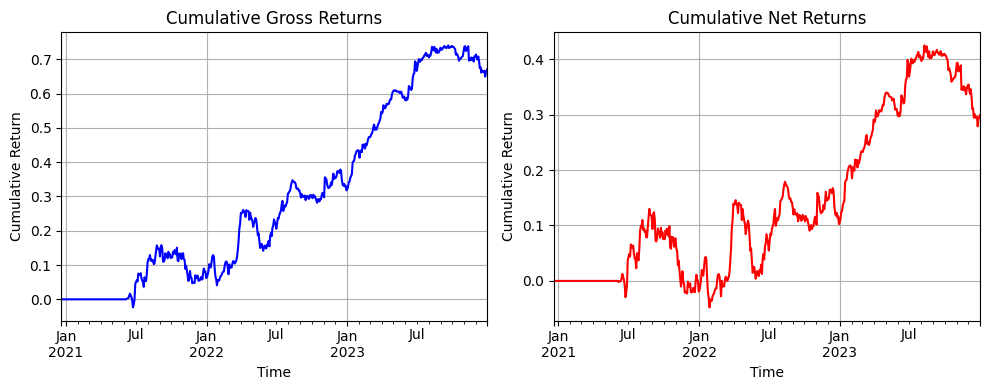

In [90]:
plot_gross_and_net_cumulative_returns(gross_returns, net_returns)

Among other variations of the signal, the variations with the highest Sharpe ratios in the training period were:

- Variation 1:
  - winsorized signal
  - time horizon for measuring price and trading: 4h
  - signal calculation type: percent difference between price and moving average
  - rolling mean type: exponentially weighted
  - alpha: 0.10
  
- Variation 2:
  - original signal
  - time horizon for measuring price and trading: 4h
  - signal calculation type: percent difference between price and moving average
  - rolling mean type: exponentially weighted
  - alpha: 0.10

- Variation 3:
  - winsorized signal
  - time horizon for measuring price and trading: 4h
  - signal calculation type: percent difference between price and moving average
  - rolling mean type: simple rolling
  - window size for simple rolling mean: 24 periods

All had large drawdowns during the training period, which is one downside but these variations all had Sharpe ratios that make them worth selecting.

# Variation 1

## Training Period

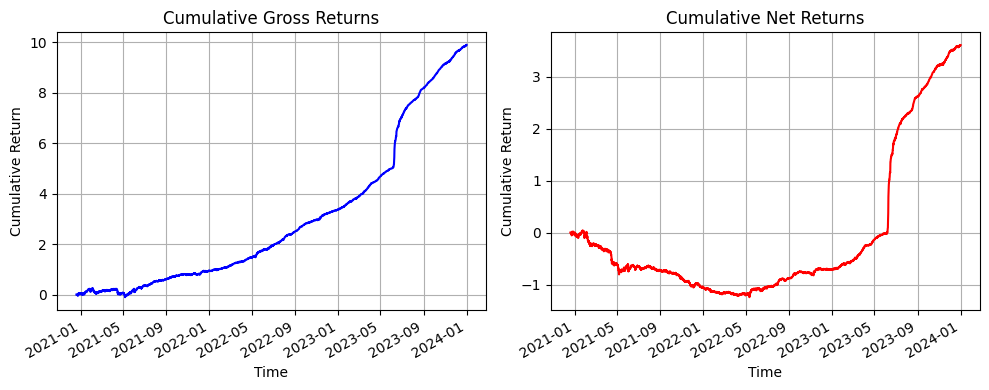

In [91]:
train_px_df = horizon_to_training_px[4]
signal_type = SignalCalculation.PERCENT
rolling_mean_type = RollingMean.EXPONENTIAL_ROLLING_MEAN
num_periods = None
alpha = 0.10

transformed_signal = get_winsorized_transformed_signal(
    train_px_df, rolling_mean_type, signal_type, num_periods, alpha)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, train_px_df)

plot_gross_and_net_cumulative_returns(gross_returns, net_returns)

## Testing Period

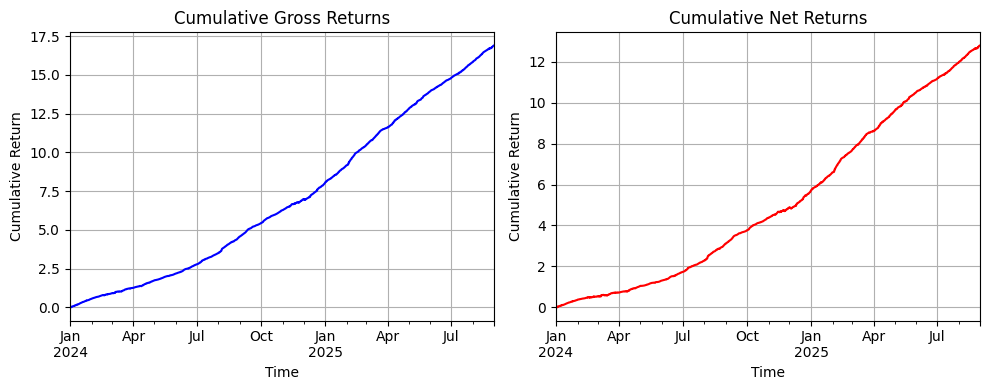

In [92]:
px_df = px
signal_type = SignalCalculation.PERCENT
rolling_mean_type = RollingMean.EXPONENTIAL_ROLLING_MEAN
num_periods = None
alpha = 0.10

transformed_signal = get_winsorized_transformed_signal(
    px_df, rolling_mean_type, signal_type, num_periods, alpha)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px_df)

test_gross_returns = gross_returns.loc[test_start_time_point:]
test_net_returns = net_returns.loc[test_start_time_point:]
test_px = px.loc[test_start_time_point:]

plot_gross_and_net_cumulative_returns(test_gross_returns, test_net_returns)

In [93]:
pd.Series(get_strategy_stats(test_net_returns, 4, test_px), name = "Stats").to_frame()

,Stats
avg returns,7.676219
decorrelated avg returns,7.700289
volatility,0.233073
sharpe ratio,32.934758
decorrelated sharpe ratio,33.112515
max drawdown,-1.653770
max drawdown duration,7.666667
alpha_BTC,0.003517
beta_BTC,-0.032444


# Variation 2

## Training Period

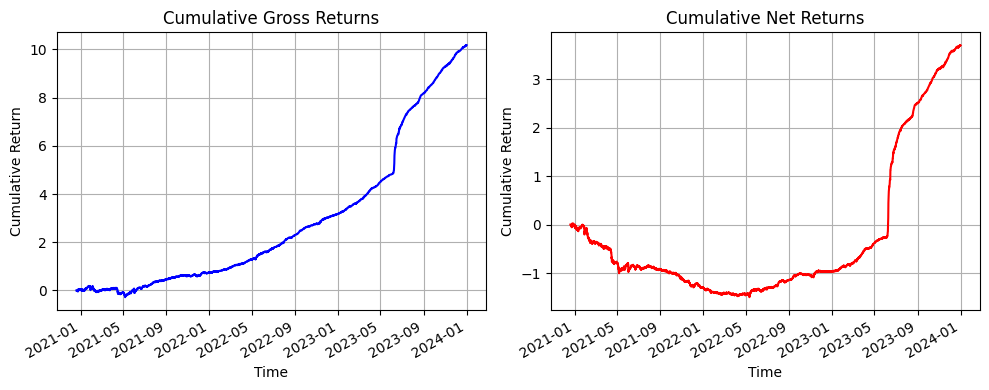

In [94]:
train_px_df = horizon_to_training_px[4]
signal_type = SignalCalculation.PERCENT
rolling_mean_type = RollingMean.EXPONENTIAL_ROLLING_MEAN
num_periods = None
alpha = 0.10

transformed_signal = get_transformed_signal(
    train_px_df, rolling_mean_type, signal_type, num_periods, alpha)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, train_px_df)

plot_gross_and_net_cumulative_returns(gross_returns, net_returns)

## Testing Period

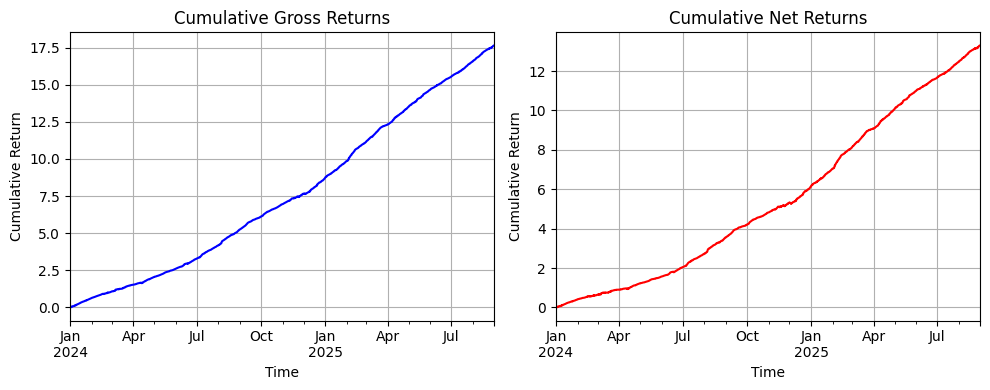

In [95]:
px_df = px
signal_type = SignalCalculation.PERCENT
rolling_mean_type = RollingMean.EXPONENTIAL_ROLLING_MEAN
num_periods = None
alpha = 0.10

transformed_signal = get_transformed_signal(
    px_df, rolling_mean_type, signal_type, num_periods, alpha)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px_df)

test_gross_returns = gross_returns.loc[test_start_time_point:]
test_net_returns = net_returns.loc[test_start_time_point:]
test_px = px.loc[test_start_time_point:]

plot_gross_and_net_cumulative_returns(test_gross_returns, test_net_returns)

In [96]:
pd.Series(get_strategy_stats(test_net_returns, 4, test_px), name = "Stats").to_frame()

,Stats
avg returns,7.977304
decorrelated avg returns,7.957468
volatility,0.239693
sharpe ratio,33.281285
decorrelated sharpe ratio,33.263135
max drawdown,-0.679951
max drawdown duration,4.333333
alpha_BTC,0.003634
beta_BTC,0.031268


# Variation 3

## Training Period

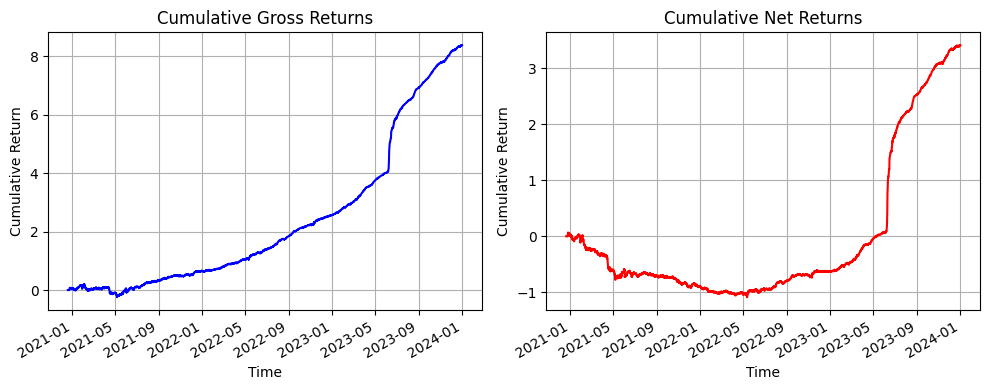

In [97]:
train_px_df = horizon_to_training_px[4]
signal_type = SignalCalculation.PERCENT
rolling_mean_type = RollingMean.SIMPLE_ROLLING_MEAN
num_periods = 24
alpha = 1.00

transformed_signal = get_winsorized_transformed_signal(
    train_px_df, rolling_mean_type, signal_type, num_periods, alpha)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, train_px_df)

plot_gross_and_net_cumulative_returns(gross_returns, net_returns)

## Testing Period

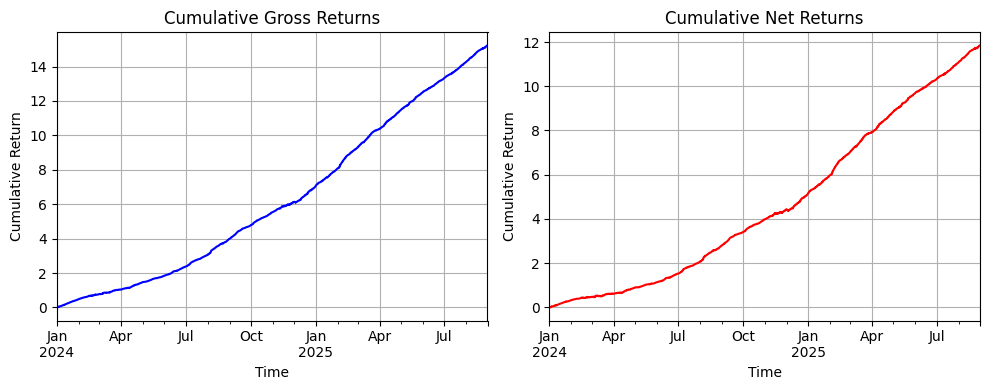

In [98]:
px_df = px
signal_type = SignalCalculation.PERCENT
rolling_mean_type = RollingMean.SIMPLE_ROLLING_MEAN
num_periods = 24
alpha = 1.00

transformed_signal = get_winsorized_transformed_signal(
    px_df, rolling_mean_type, signal_type, num_periods, alpha)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px_df)

test_gross_returns = gross_returns.loc[test_start_time_point:]
test_net_returns = net_returns.loc[test_start_time_point:]
test_px = px.loc[test_start_time_point:]

plot_gross_and_net_cumulative_returns(test_gross_returns, test_net_returns)

In [99]:
pd.Series(get_strategy_stats(test_net_returns, 4, test_px), name = "Stats").to_frame()

,Stats
avg returns,7.105732
decorrelated avg returns,7.130487
volatility,0.231711
sharpe ratio,30.666348
decorrelated sharpe ratio,30.849079
max drawdown,-1.623979
max drawdown duration,8.000000
alpha_BTC,0.003256
beta_BTC,-0.033751
